In [1]:
import pandas as pd
import numpy as np
import os 
import re
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import time

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.style.use('bmh')

from nltk.util import bigrams
from pathlib import Path
%pprint # turn pretty printing off 

Pretty printing has been turned OFF


# Reorganize meta data for articles

In [ ]:
os.chdir('../data/bernama')

In [2]:
# Get all meta files' names
meta_data = [file for file in os.listdir() if '.csv' in file]
meta_data[0:10]

['berita_dalam_negeri_01-01-2017.csv', 'berita_dalam_negeri_01-01-2018.csv', 'berita_dalam_negeri_01-01-2019.csv', 'berita_dalam_negeri_01-01-2020.csv', 'berita_dalam_negeri_01-01-2021.csv', 'berita_dalam_negeri_01-02-2017.csv', 'berita_dalam_negeri_01-02-2018.csv', 'berita_dalam_negeri_01-02-2019.csv', 'berita_dalam_negeri_01-02-2020.csv', 'berita_dalam_negeri_01-02-2021.csv']

In [6]:
# Organize files by year
years = ['2017', '2018', '2019', '2020', '2021']
dict_year = {}

for year in years:
    dict_year[year] = [file for file in meta_data if year in file]
    
# get number of files each year
[(key, len(value)) for key, value in dict_year.items()] 

[('2017', 350), ('2018', 350), ('2019', 363), ('2020', 366), ('2021', 182)]

In [7]:
# Move meta data to respective folders by year
for year, files in dict_year.items():
    for file in files:
        Path(file).rename('articles_meta/' + year + '/' + file)

# Variables cleaning

In [45]:
year = '2021'
df = pickle.load(open('../data/bernama/pickle/article_'+ year, 'rb'))
df.drop_duplicates(subset='title', inplace=True)
print(df.shape)
df.head()

(13812, 4)


,title,date,author,article
0,1 JUN PENGURUSAN KES RAYUAN NAJIB BERHUBUNG PE...,04/05/2021,JOCELYN ANN DRAGON,Mahkamah Rayuan menetapkan 1 Jun untuk s...
1,10 DITAHAN SEMASA LEKA BERJUDI DALAM SEMAK,24/06/2021,SITI SALWA SHAARI,Polis menahan 10 individu termasuk tiga wanita...
2,10 INDIVIDU DARIPADA DUA KELUARGA DITAHAN MERU...,29/05/2021,SHAIDATHUL SUHANA ROS,Seramai 10 individu daripada dua keluarga...
3,10 KAWASAN DI SEMENANJUNG REKOD GELOMBANG HABA...,01/03/2021,MOHD FHARKHAN ABDUL GHAPAR,Sebanyak 10 kawasan di Semenanjung Malays...
4,10 KRU WARGA INDONESIA TERSELAMAT BOT KARAM DI...,26/04/2021,KAMARUL HALIM M KAMAL,Seramai 10 warga Indonesia kru bot barter trad...


In [46]:
# Convert date from str to datetime 
df.date = pd.to_datetime(df.date, format='%d/%m/%Y')
df = df.loc[df.date.dt.year==int(year), :]
df.date.describe(datetime_is_numeric=True)

count                            13812
mean     2021-03-30 23:17:02.762814976
min                2021-01-01 00:00:00
25%                2021-02-14 00:00:00
50%                2021-03-29 00:00:00
75%                2021-05-17 00:00:00
max                2021-07-01 00:00:00
Name: date, dtype: object

Text(0.5, 1.0, 'Number of Malay articles per month in 2021')

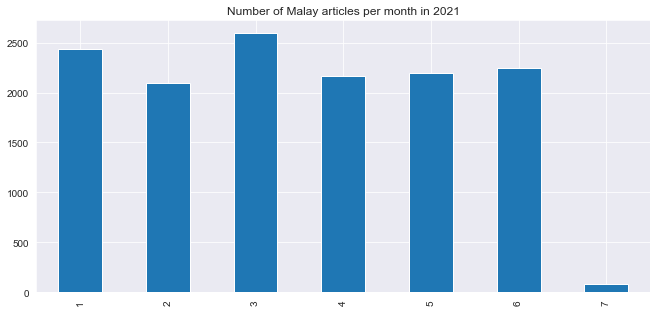

In [47]:
# Number of articles per month 
fig, ax = plt.subplots()
bar = df.date.dt.month.value_counts().sort_index().plot(kind='bar', figsize=(11,5))
#ax.bar_label(bar,  label_type='center')
plt.title('Number of Malay articles per month in ' + year)

Text(0.5, 1.0, 'Number of Malay articles per day in month 1')

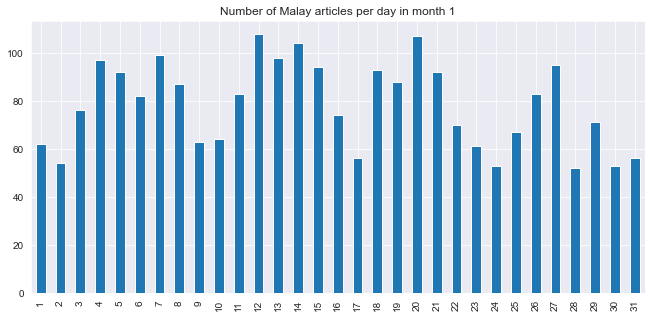

In [48]:
# Number of articles per day
month = 1
fig, ax = plt.subplots()
bar = df.loc[df.date.dt.month == month, 'date'].dt.day.value_counts().sort_index().plot(kind='bar', figsize=(11,5))
#ax.bar_label(bar,  label_type='center')
plt.title('Number of Malay articles per day in month ' + str(month))

2636


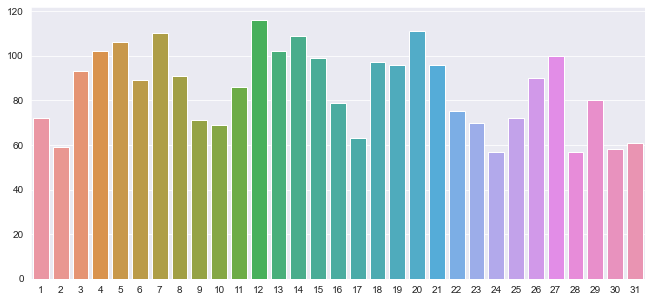

In [49]:
# Number of articles per day (according to metadata)
files = [file for file in os.listdir('../data/bernama/articles_meta/' + year) if '-01-' in file]

no_days = []

for file in files:
    df_day = pd.read_csv('../data/bernama/articles_meta/' + year + '/' + file)
    no_days.append(df_day.shape[0])

fig, ax = plt.subplots(figsize=(11,5))
sns.barplot(x=list(range(1, len(files)+1)), y=no_days)
print(sum(no_days))

# Text preprocessing

In [50]:
def clean_text(text, unigrams=True, punctuation=True, keywords=None):
    '''Assume text is of type string. Convert text into lowercase.
    Remove stopwords and punctuations. Tokenize text into unigrams/bigrams. 
    
    Args:
        text (str): text to be tokenized.
        unigrams (bool): tokenize text into unigrams if True, bigrams if False.
        punctuation (bool): remove punctuation if True. 
        
    Returns:
        a list of tokens.
    '''
    # Covnvert text into lowercase
    text = text.lower()
    text = text.replace('&amp;', '&').replace('\n', ' ').replace('  ', ' ')
    
    # Remove url(s)  
    text = re.sub('https:\/\/[^\s]+', '', text)
    
    # Remove punctuations
    if punctuation == True:
        punctuations = string.punctuation + '‘’“”...'
        text = ''.join([char for char in text if char not in punctuations])
    
    # Remove number 
    text = re.sub('[0-9]+', '', text)

    if unigrams == True:   
        # Tokenize texts into unigrams
        # Split texts by keywords 
        tokens = re.split('(' + '|'.join(keywords) + ')', text)
        
        # Split the rest of the text
        tokens = [words.split() if words not in keywords else [words] for words in tokens]
        tokens = [word for words in tokens for word in words]
        
        # Remove word that consists only of a single character
        tokens = [token for token in tokens if len(token)!=1]
        
    else:
        # Tokenize texts into bigrams
        tokens = text.split()
        
        # Remove word that consists only of a single character
        tokens = [token for token in tokens if len(token)!=1]
        tokens = [' '.join(bigram) for bigram in list(bigrams(tokens))]

    return tokens

In [51]:
key = ['kaum melayu', 'bangsa melayu', 'orang melayu', 'masyarakat melayu',
       'kaum cina', 'bangsa cina', 'orang cina', 'masyarakat cina',
       'kaum india', 'bangsa india', 'orang india', 'masyarakat india']

In [52]:
# Tokenize text into unigrams 
df['tokens'] = df.article.apply(clean_text, args=(True, True, key))

# Count number of tokens
df['no_tokens'] = df.tokens.apply(lambda text: len(text))
df.head()

,title,date,author,article,tokens,no_tokens
0,1 JUN PENGURUSAN KES RAYUAN NAJIB BERHUBUNG PE...,2021-05-04,JOCELYN ANN DRAGON,Mahkamah Rayuan menetapkan 1 Jun untuk s...,"[mahkamah, rayuan, menetapkan, jun, untuk, sat...",259
1,10 DITAHAN SEMASA LEKA BERJUDI DALAM SEMAK,2021-06-24,SITI SALWA SHAARI,Polis menahan 10 individu termasuk tiga wanita...,"[polis, menahan, individu, termasuk, tiga, wan...",175
2,10 INDIVIDU DARIPADA DUA KELUARGA DITAHAN MERU...,2021-05-29,SHAIDATHUL SUHANA ROS,Seramai 10 individu daripada dua keluarga...,"[seramai, individu, daripada, dua, keluarga, d...",158
3,10 KAWASAN DI SEMENANJUNG REKOD GELOMBANG HABA...,2021-03-01,MOHD FHARKHAN ABDUL GHAPAR,Sebanyak 10 kawasan di Semenanjung Malays...,"[sebanyak, kawasan, di, semenanjung, malaysia,...",192
4,10 KRU WARGA INDONESIA TERSELAMAT BOT KARAM DI...,2021-04-26,KAMARUL HALIM M KAMAL,Seramai 10 warga Indonesia kru bot barter trad...,"[seramai, warga, indonesia, kru, bot, barter, ...",127


In [53]:
# Tokenize text into bigrams  
df['bigrams'] = df.article.apply(clean_text, unigrams=False)
df.head()

,title,date,author,article,tokens,no_tokens,bigrams
0,1 JUN PENGURUSAN KES RAYUAN NAJIB BERHUBUNG PE...,2021-05-04,JOCELYN ANN DRAGON,Mahkamah Rayuan menetapkan 1 Jun untuk s...,"[mahkamah, rayuan, menetapkan, jun, untuk, sat...",259,"[mahkamah rayuan, rayuan menetapkan, menetapka..."
1,10 DITAHAN SEMASA LEKA BERJUDI DALAM SEMAK,2021-06-24,SITI SALWA SHAARI,Polis menahan 10 individu termasuk tiga wanita...,"[polis, menahan, individu, termasuk, tiga, wan...",175,"[polis menahan, menahan individu, individu ter..."
2,10 INDIVIDU DARIPADA DUA KELUARGA DITAHAN MERU...,2021-05-29,SHAIDATHUL SUHANA ROS,Seramai 10 individu daripada dua keluarga...,"[seramai, individu, daripada, dua, keluarga, d...",158,"[seramai individu, individu daripada, daripada..."
3,10 KAWASAN DI SEMENANJUNG REKOD GELOMBANG HABA...,2021-03-01,MOHD FHARKHAN ABDUL GHAPAR,Sebanyak 10 kawasan di Semenanjung Malays...,"[sebanyak, kawasan, di, semenanjung, malaysia,...",192,"[sebanyak kawasan, kawasan di, di semenanjung,..."
4,10 KRU WARGA INDONESIA TERSELAMAT BOT KARAM DI...,2021-04-26,KAMARUL HALIM M KAMAL,Seramai 10 warga Indonesia kru bot barter trad...,"[seramai, warga, indonesia, kru, bot, barter, ...",127,"[seramai warga, warga indonesia, indonesia kru..."


In [54]:
pickle.dump(df, open("data/data_" + year + '_clean', "wb"))

# EDA 

In [2]:
# Import data
df = pd.DataFrame()

for year in range(2017, 2022):
    df_temp = pickle.load(open('data/data_' + str(year) + '_clean', 'rb'))
    df = pd.concat([df, df_temp])

print(df.shape)
df.head()

(154946, 7)


,title,date,author,article,tokens,no_tokens,bigrams
0,MAHKAMAH PERSEKUTUAN TOLAK PERMOHONAN RAYUAN A...,2017-05-09,JOCELYN ANN DRAGON,"Usaha aktivis, Haris Fathillah Mohd Ibrah...","[usaha, aktivis, haris, fathillah, mohd, ibrah...",286,"[usaha aktivis, aktivis haris, haris fathillah..."
1,AGONG DIRAI PENUH ISTIADAT PADA MAJLIS SANTAPA...,2017-05-07,BALQIS JAMALUDIN,Sultan Muhammad V malam ini berkenan berangkat...,"[sultan, muhammad, malam, ini, berkenan, beran...",104,"[sultan muhammad, muhammad malam, malam ini, i..."
2,INSIDEN JUMAAT: JANGAN PARKIR IKUT SUKA KERANA...,2017-05-08,NURQALBY MOHD REDA,"Jangan parkir ikut suka kerana hendak solat, ...","[jangan, parkir, ikut, suka, kerana, hendak, s...",156,"[jangan parkir, parkir ikut, ikut suka, suka k..."
3,60 HINGGA 70 PENAGIH BAHARU DIREKOD SETIAP HAR...,2017-04-15,ROZAINAH BINTI ABDUL RAHIM,Secara purata antara 60 dan 70 orang di negara...,"[secara, purata, antara, dan, orang, di, negar...",265,"[secara purata, purata antara, antara dan, dan..."
4,"942,000 HEKTAR TANAH DIWARTA KAWASAN PERLINDUN...",2017-05-03,NOOR BAKHTIAR AHMAD,S a r a w a k m e w a r t a k a n s e j u ...,"[hektar, termasuk, kawasan, tadahan, air, seba...",271,"[hektar termasuk, termasuk kawasan, kawasan ta..."


In [3]:
# Get no. of articles each year
df.date.dt.year.value_counts().sort_index()

2017    35950
2018    37277
2019    38064
2020    29843
2021    13812
Name: date, dtype: int64

In [4]:
# Get no. of tokens each year
print(df.no_tokens.sum())
df.groupby(df.date.dt.year)['no_tokens'].sum()

39210452


date
2017    8665156
2018    9188407
2019    9764743
2020    7901731
2021    3690415
Name: no_tokens, dtype: int64

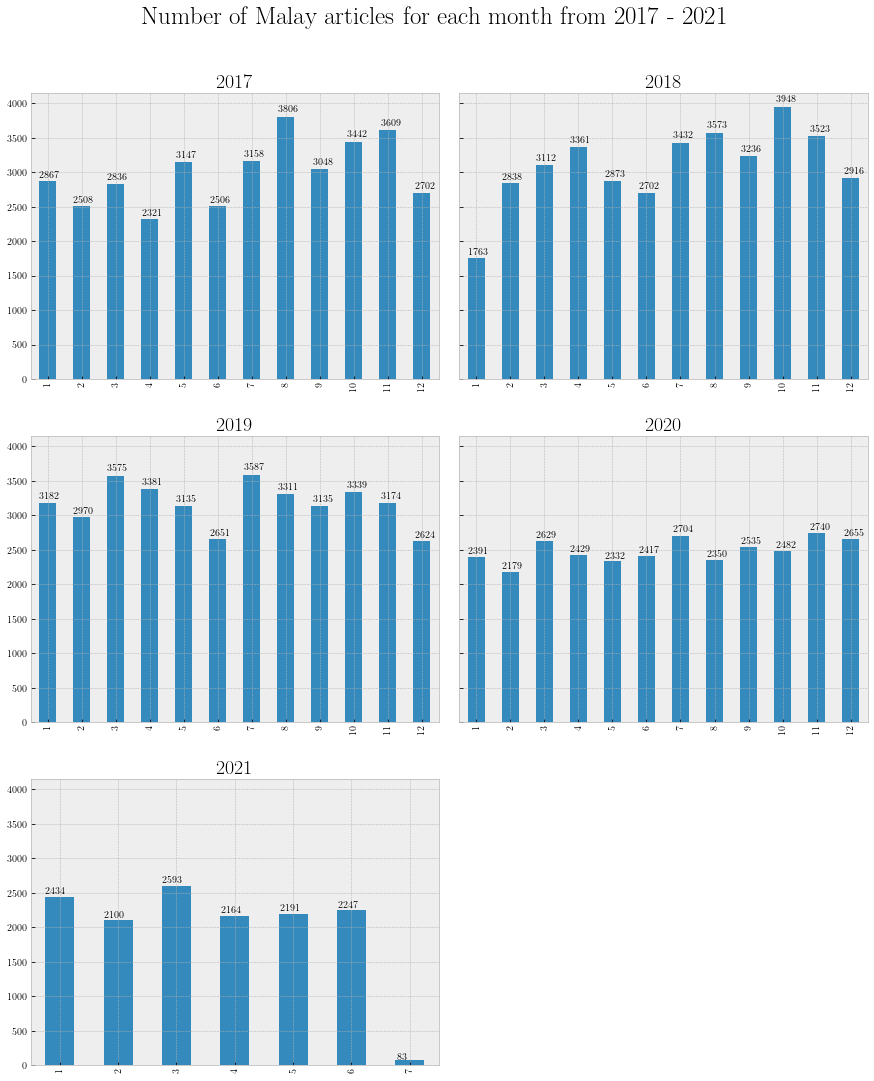

In [5]:
# Plot no. of articles per month
fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharey=True)
axes = axes.flatten()
title = 'Number of Malay articles for each month from 2017 - 2021'
years = df.date.dt.year.unique()

for idx in range(len(axes)):
    ax = axes[idx]
    if idx <= len(years)-1:
        year = years[idx]
        data = df.loc[df.date.dt.year == year, 'date']
        data.dt.month.value_counts().sort_index().plot(kind='bar', ax=ax)
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
        ax.set_title(year, fontdict={'fontsize': 20})
    else:
        ax.set_axis_off()

fig.suptitle(title, fontsize=25)
plt.subplots_adjust(top=0.90, bottom=0, wspace=0.05, hspace=0.2)
plt.savefig('figs/malay_no_articles_monthly.eps', format='eps')

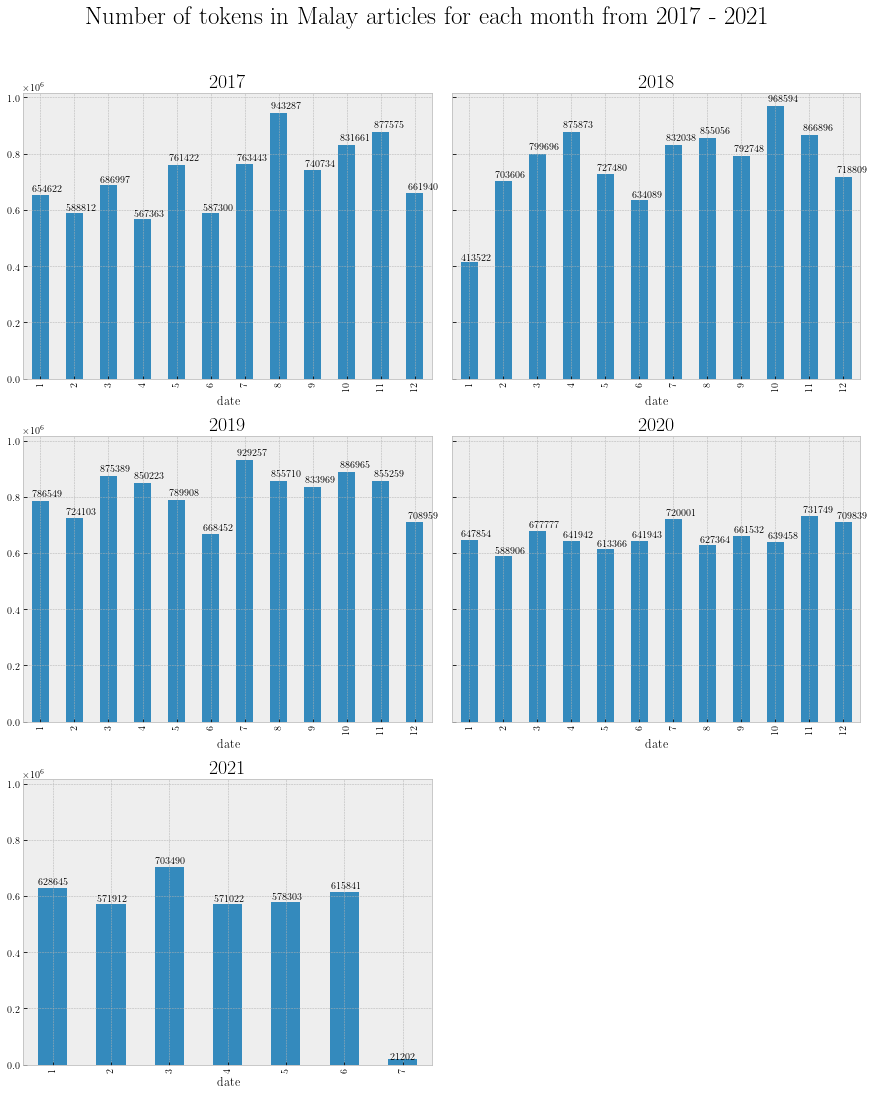

In [6]:
# Plot no. of tokens per month
fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharey=True)
axes = axes.flatten()
title = 'Number of tokens in Malay articles for each month from 2017 - 2021'
years = df.date.dt.year.unique()

for idx in range(len(axes)):
    ax = axes[idx]
    if idx <= len(years)-1:
        year = years[idx]
        data = df.loc[df.date.dt.year == year, :]
        data.groupby(data.date.dt.month)['no_tokens'].sum().sort_index().plot(kind='bar', ax=ax)
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
        ax.set_title(year, fontdict={'fontsize': 20})
    else:
        ax.set_axis_off()

fig.suptitle(title, fontsize=25)
plt.subplots_adjust(top=0.90, bottom=0, wspace=0.05, hspace=0.2)
plt.savefig('figs/malay_no_tokens_monthly.eps', format='eps')

count    154946.00000
mean        253.05882
std         122.39048
min           0.00000
25%         174.00000
50%         237.00000
75%         308.00000
max       11669.00000
Name: no_tokens, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


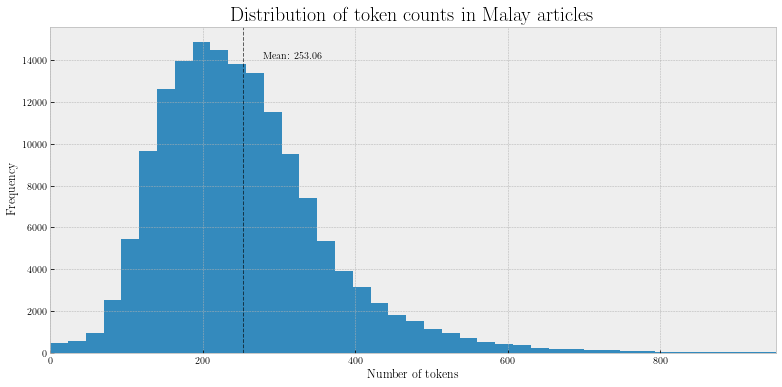

In [5]:
# Plot distribution of tokens number
print(df.no_tokens.describe())
fig, ax = plt.subplots(figsize=(13, 6))
ax = df.no_tokens.plot(kind='hist', bins=500)

plt.axvline(df.no_tokens.mean(), linestyle='dashed', color='black', alpha=0.6, linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(df.no_tokens.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df.no_tokens.mean()))

ax.set_xlabel('Number of tokens')
ax.set_title('Distribution of token counts in Malay articles', fontdict={'fontsize': 20})
ax.set_xlim(0, df.no_tokens.quantile(0.999))
plt.savefig('figs/malay_dist_tokens_count.eps', format='eps')

count    154946.00000
mean        253.05882
std         122.39048
min           0.00000
25%         174.00000
50%         237.00000
75%         308.00000
max       11669.00000
Name: no_tokens, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


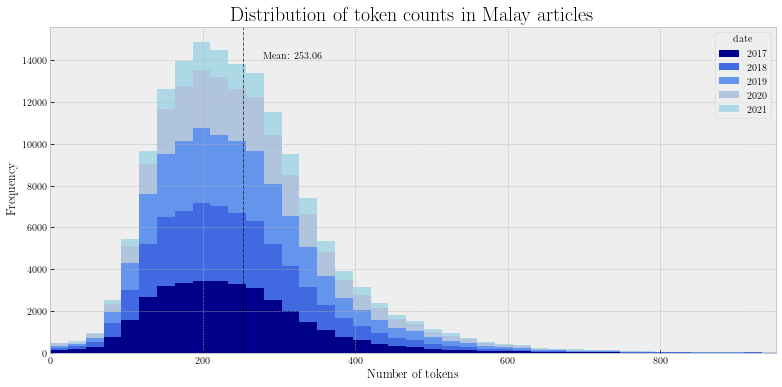

In [6]:
# Plot distribution of tokens number by years 
print(df.no_tokens.describe())

df_hist = df.loc[:, ['no_tokens', 'date']]
df_hist['date'] = df_hist.date.dt.year
df_hist = df_hist.pivot(columns='date', values='no_tokens')
ax = df_hist.plot.hist(stacked=True, bins=500, figsize=(13, 6), color=['darkblue', 'royalblue', 'cornflowerblue', 'lightsteelblue', 'lightblue'])

plt.axvline(df.no_tokens.mean(), linestyle='dashed', color='black', alpha=0.6, linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(df.no_tokens.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df.no_tokens.mean()))

ax.set_xlabel('Number of tokens')
ax.set_title('Distribution of token counts in Malay articles', fontdict={'fontsize': 20})
ax.set_xlim(0, df.no_tokens.quantile(0.999))
plt.savefig('figs/malay_dist_tokens_count_by_year.eps', format='eps')

count     39210452
unique          64
top              5
freq       6806210
Name: tokens, dtype: int64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


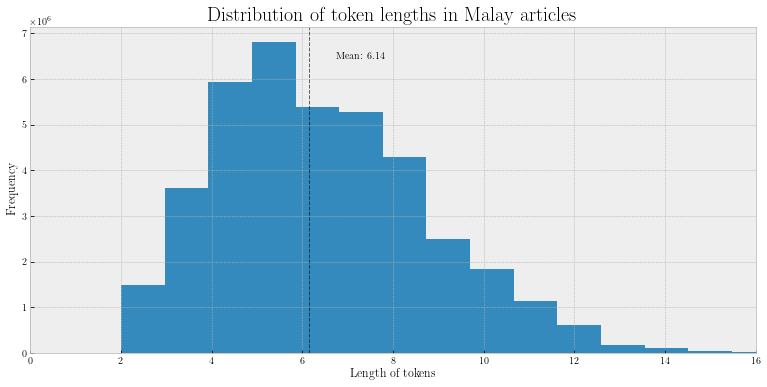

In [7]:
# Plot distribution of tokens length
tokens_len = df.tokens.apply(lambda words: [len(word) for word in words]).explode()
print(tokens_len.describe())

fig, ax = plt.subplots(figsize=(13, 6))
ax = tokens_len.plot(kind='hist', bins=80, figsize=(13, 6))

plt.axvline(tokens_len.mean(), linestyle='dashed', color='black', alpha=0.6, linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(tokens_len.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(tokens_len.mean()))

ax.set_xlabel('Length of tokens')
ax.set_title('Distribution of token lengths in Malay articles', fontdict={'fontsize': 20})
ax.set_xlim(0, tokens_len.quantile(0.999))
plt.savefig('figs/malay_dist_tokens_length.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


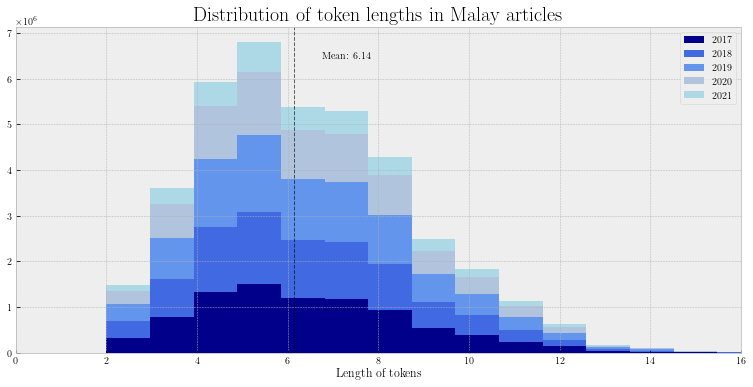

In [9]:
# Plot distribution of tokens length by years
df_hist = df.loc[:, ['tokens', 'date']]
df_hist['tokens'] = df_hist.tokens.apply(lambda words: [len(word) for word in words])
df_hist['date'] = df_hist.date.dt.year
df_hist = df_hist.pivot(columns='date', values='tokens')
df_hist = [df_hist[year].explode() for year in df_hist.columns]

fig, ax = plt.subplots(figsize=(13, 6))
plt.hist(df_hist, stacked=True, bins=80, label=list(range(2017, 2022)), color=['darkblue', 'royalblue', 'cornflowerblue', 'lightsteelblue', 'lightblue'])

plt.axvline(tokens_len.mean(), linestyle='dashed', color='black', alpha=0.6, linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(tokens_len.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(tokens_len.mean()))

ax.legend()
ax.set_xlabel('Length of tokens')
ax.set_title('Distribution of token lengths in Malay articles', fontdict={'fontsize': 20})
ax.set_xlim(0, tokens_len.quantile(0.999))
plt.savefig('figs/malay_dist_tokens_length_by_year.eps', format='eps')

In [ ]:
# Plot most common unigrams

In [ ]:
# Plot most common bigrams